In [1]:
import os    
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float32"

import numpy as np
from sklearn.utils import shuffle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import math

from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, UpSampling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.layers.core import Flatten
from keras.constraints import maxnorm

import keras.regularizers

from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


img_rows = 32
img_cols = 32


Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/home/mrafi123/anaconda3/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce 920M (0000:08:00.0)


In [2]:
#test for gpu
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float32, (False,))>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.918359 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [3]:
import seaborn as sns

sns.set(style='white', context='notebook', palette='deep')


In [4]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


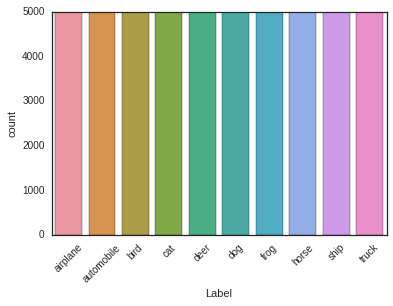

In [5]:
%matplotlib inline

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
g = sns.countplot(y_train[:,0])
g.set_xticklabels(classes,rotation = 45)
g = g.set_xlabel('Label')

In [6]:
# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test,  10)

In [8]:
print (x_train.shape) ## 3,,32,32
image = x_train.reshape(x_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
print (image[0].shape) ## 3,,32,32

(50000, 3, 32, 32)
(32, 32, 3)


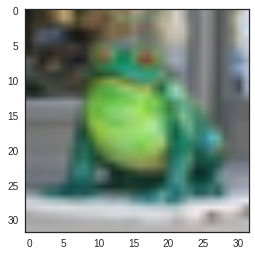

In [9]:
# Some examples
g = plt.imshow(image[19])

## Split Data for Supervised and Unsupervised Training

In [10]:
from sklearn.model_selection import train_test_split

l_images_train, u_images_train, l_labels_train, u_labels_train = train_test_split(
    x_train,y_train,test_size=48000, random_state=42)

In [11]:
print (l_images_train.shape)
print (u_images_train.shape)
print (l_labels_train.shape)
print (u_labels_train.shape)

(2000, 3, 32, 32)
(48000, 3, 32, 32)
(2000, 10)
(48000, 10)


## Start Supervised Learning

In [12]:
#Set the CNN model 
model = Sequential()
#model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 # activation ='relu', input_shape = (32,32,3)))
model.add(Convolution2D(32,3, 3, border_mode='same',input_shape=(3, 32, 32), activation='relu'))

#model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Convolution2D(32,3, 3, border_mode='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
model.add(Convolution2D(64,3, 3, border_mode='same',activation='relu'))

#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))

model.add(Convolution2D(64,3, 3, border_mode='same',activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
model.add(Convolution2D(86,3, 3, border_mode='same',activation='relu'))


#model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
model.add(Convolution2D(86,3, 3, border_mode='same',activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [13]:
from keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(lr=0.001, decay=1e-6)

In [14]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Set a learning_rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
epochs = 30 # Turn epochs to 80 to get 0.87 accuracy
batch_size = 64

In [17]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = \
train_test_split(l_images_train, l_labels_train, test_size = 0.1, random_state=random_seed)


In [18]:
print (l_images_train.shape)
print (l_labels_train.shape)
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)


(2000, 3, 32, 32)
(2000, 10)
(1800, 3, 32, 32)
(1800, 10)
(200, 3, 32, 32)
(200, 10)


In [26]:
# With data augmentation to prevent the overfitting (accuracy 0.87)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [29]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size, shuffle=True),
                              nb_epoch = epochs, samples_per_epoch = X_train.shape[0],
                              validation_data = (X_val,Y_val),
                               callbacks=[learning_rate_reduction])

Epoch 1/30
1800/1800 [==============================] - 13s - loss: 2.1528 - acc: 0.1906 - val_loss: 2.1218 - val_acc: 0.2200
Epoch 2/30
1800/1800 [==============================] - 13s - loss: 2.1235 - acc: 0.2144 - val_loss: 3.0545 - val_acc: 0.1000
Epoch 3/30
1800/1800 [==============================] - 13s - loss: 2.0854 - acc: 0.2144 - val_loss: 2.4873 - val_acc: 0.0950
Epoch 4/30
1800/1800 [==============================] - 13s - loss: 2.0293 - acc: 0.2389 - val_loss: 2.6396 - val_acc: 0.1000
Epoch 5/30
1792/1800 [============================>.] - ETA: 0s - loss: 1.9833 - acc: 0.2489
Epoch 00004: reducing learning rate to 0.0005000000237487257.
1800/1800 [==============================] - 13s - loss: 1.9829 - acc: 0.2489 - val_loss: 2.5728 - val_acc: 0.1350
Epoch 6/30
1800/1800 [==============================] - 13s - loss: 1.9075 - acc: 0.2650 - val_loss: 2.5431 - val_acc: 0.1100
Epoch 7/30
1800/1800 [==============================] - 13s - loss: 1.8239 - acc: 0.3261 - val_loss:

In [32]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.06654905548
Test accuracy: 0.2967


In [30]:
y_test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [31]:
x_test

array([[[[ 0.61960784,  0.62352941,  0.64705882, ...,  0.5372549 ,
           0.49411765,  0.45490196],
         [ 0.59607843,  0.59215686,  0.62352941, ...,  0.53333333,
           0.49019608,  0.46666667],
         [ 0.59215686,  0.59215686,  0.61960784, ...,  0.54509804,
           0.50980392,  0.47058824],
         ..., 
         [ 0.26666667,  0.16470588,  0.12156863, ...,  0.14901961,
           0.05098039,  0.15686275],
         [ 0.23921569,  0.19215686,  0.1372549 , ...,  0.10196078,
           0.11372549,  0.07843137],
         [ 0.21176471,  0.21960784,  0.17647059, ...,  0.09411765,
           0.13333333,  0.08235294]],

        [[ 0.43921569,  0.43529412,  0.45490196, ...,  0.37254902,
           0.35686275,  0.33333333],
         [ 0.43921569,  0.43137255,  0.44705882, ...,  0.37254902,
           0.35686275,  0.34509804],
         [ 0.43137255,  0.42745098,  0.43529412, ...,  0.38431373,
           0.37254902,  0.34901961],
         ..., 
         [ 0.48627451,  0.392156

In [46]:
y_pred = model.predict(x_test)

In [47]:
y_pred[0]

array([  1.05853513e-04,   1.00144674e-03,   1.95034519e-02,
         6.66136980e-01,   2.68864911e-02,   1.30998537e-01,
         1.37116164e-01,   1.78372227e-02,   1.61508040e-04,
         2.52373167e-04], dtype=float32)

In [48]:
y_pred_new = y_pred[:, :10]  # First 10 columns of full_array


In [49]:
y_pred_new[1]

array([  1.14289239e-01,   4.46367413e-01,   2.23175809e-03,
         7.35852169e-04,   2.43850611e-03,   4.43213998e-04,
         9.43116756e-05,   4.91843512e-03,   1.75190508e-01,
         2.53290802e-01], dtype=float32)

In [50]:
y_pred_new = np.ndarray.argmax(y_pred_new,axis=1)

In [51]:
y_pred_new

array([3, 1, 8, ..., 6, 6, 7])

In [52]:
y_pred_new.shape

(10000,)

In [53]:
y_test_new = np.ndarray.argmax(y_test,axis=1)

In [54]:
y_test_new

array([3, 8, 8, ..., 5, 1, 7])

In [55]:
num=10000
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred_new[i].all() == y_test_new[i].all():
        if np.array_equal(y_pred_new[i],y_test_new[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")

tested  10000 digits
correct:  2967 wrong:  7033 error rate:  70.33 %
got correctly  29.67 %


# With a Supervised Training using 2000 training samples
# we get around 30% test accuracy

## Start Unsupervised Learning - Exemplar, Augumented, Pseudo Labels

No of Surrogate classes 50 - 32000 ----8000 is optimum
No of Samples Per Surrogate class - 1 to 300
According to the paper

but for our purpose
can we random select say 100 images - check thier distribution
loop each of this image and automatically image augmentation for 200 images
Label this 200 images as one surrogate classes
100*200 = 20000 images and 100 labels



In [12]:
no_of_surrogate_classes = 1000
surr_labels_train = np.arange(no_of_surrogate_classes)

In [13]:
surr_labels_train = surr_labels_train.reshape(no_of_surrogate_classes,1)
print(surr_labels_train.shape)
print (len(surr_labels_train))

(1000, 1)
1000


In [14]:
surr_labels_train

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [15]:
print(u_images_train.shape)
print(u_images_train[0])

(48000, 3, 32, 32)
[[[ 0.7254902   0.70196078  0.7372549  ...,  0.51372549  0.62745098
    0.79215686]
  [ 0.71764706  0.71372549  0.76862745 ...,  0.5254902   0.62352941
    0.80392157]
  [ 0.71764706  0.71372549  0.77647059 ...,  0.50980392  0.60392157  0.8       ]
  ..., 
  [ 0.42352941  0.42352941  0.40392157 ...,  0.40784314  0.41568627
    0.40784314]
  [ 0.39215686  0.39607843  0.4        ...,  0.41568627  0.41568627
    0.41568627]
  [ 0.37647059  0.36078431  0.36078431 ...,  0.41568627  0.41176471
    0.41568627]]

 [[ 0.7254902   0.69019608  0.71764706 ...,  0.47843137  0.59607843
    0.77647059]
  [ 0.72156863  0.70588235  0.75294118 ...,  0.48627451  0.59215686
    0.78431373]
  [ 0.7254902   0.70980392  0.76470588 ...,  0.47058824  0.57254902
    0.78431373]
  ..., 
  [ 0.43921569  0.43921569  0.41960784 ...,  0.40392157  0.41176471
    0.40392157]
  [ 0.40392157  0.41176471  0.41568627 ...,  0.41176471  0.41176471
    0.41176471]
  [ 0.38823529  0.37254902  0.37254902 ...

In [16]:
split = u_images_train.shape[0]/no_of_surrogate_classes
print (split)

divided_input = np.split(u_images_train, split)
X_train = divided_input[0]
print(X_train.shape)
divided_output = np.split(u_labels_train, split)
Y_train = divided_output[0]

unique, counts = numpy.unique(np.ndarray.argmax(Y_train,axis=1), return_counts=True)
print (dict(zip(unique, counts)))

48.0
(1000, 3, 32, 32)
{0: 85, 1: 106, 2: 94, 3: 102, 4: 94, 5: 110, 6: 90, 7: 113, 8: 96, 9: 110}


In [17]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        rescale = 1.5, # If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (before applying any other transformation).
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        shear_range=0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
        zoom_range=0.2 , #Float or [lower, upper]. Range for random zoom. If a float,  [lower, upper] = [1-zoom_range, 1+zoom_range].
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        channel_shift_range = 0.1, #Range for random channel shifts.
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


Using real-time data augmentation.


In [18]:
i=0
generated_images = np.empty(shape=[0,3,32,32])
generated_labels = np.empty(shape=[0,1])


for i in range(50):
    
    for X_batch,Y_batch in datagen.flow(X_train,surr_labels_train,batch_size=len(X_train)):
        generated_images = np.concatenate((generated_images, X_batch))
        generated_labels = np.concatenate((generated_labels, Y_batch))
        break  # otherwise the generator would loop indefinitely

    i+=1
    if i >= 50:
        break


In [19]:
print (X_train.shape)
print (surr_labels_train.shape)

print (X_batch.shape)
print (Y_batch.shape)
print (generated_images.shape)
print (generated_labels.shape)


(1000, 3, 32, 32)
(1000, 1)
(1000, 3, 32, 32)
(1000, 1)
(50000, 3, 32, 32)
(50000, 1)


In [27]:
print (Y_batch)

[[246]
 [500]
 [398]
 [513]
 [795]
 [885]
 [100]
 [940]
 [382]
 [515]
 [416]
 [838]
 [527]
 [578]
 [919]
 [220]
 [613]
 [765]
 [957]
 [166]
 [925]
 [615]
 [  4]
 [204]
 [760]
 [105]
 [989]
 [167]
 [666]
 [403]
 [655]
 [610]
 [ 46]
 [324]
 [602]
 [647]
 [809]
 [326]
 [184]
 [  5]
 [545]
 [300]
 [931]
 [496]
 [196]
 [122]
 [400]
 [163]
 [772]
 [962]
 [963]
 [ 83]
 [150]
 [418]
 [583]
 [949]
 [740]
 [392]
 [727]
 [482]
 [ 97]
 [257]
 [225]
 [134]
 [923]
 [221]
 [ 72]
 [127]
 [222]
 [ 44]
 [ 78]
 [582]
 [406]
 [604]
 [732]
 [997]
 [ 88]
 [552]
 [288]
 [673]
 [706]
 [524]
 [918]
 [146]
 [888]
 [ 19]
 [280]
 [884]
 [968]
 [285]
 [751]
 [817]
 [576]
 [294]
 [321]
 [441]
 [779]
 [898]
 [306]
 [397]
 [680]
 [433]
 [254]
 [958]
 [279]
 [ 98]
 [115]
 [986]
 [835]
 [109]
 [268]
 [405]
 [212]
 [241]
 [586]
 [139]
 [323]
 [556]
 [142]
 [784]
 [656]
 [823]
 [213]
 [331]
 [893]
 [628]
 [554]
 [874]
 [453]
 [990]
 [169]
 [879]
 [207]
 [149]
 [243]
 [503]
 [639]
 [701]
 [415]
 [286]
 [616]
 [340]
 [389]

In [20]:
unique, counts = numpy.unique(generated_labels, return_counts=True)
print (dict(zip(unique, counts)))

{0.0: 50, 1.0: 50, 2.0: 50, 3.0: 50, 4.0: 50, 5.0: 50, 6.0: 50, 7.0: 50, 8.0: 50, 9.0: 50, 10.0: 50, 11.0: 50, 12.0: 50, 13.0: 50, 14.0: 50, 15.0: 50, 16.0: 50, 17.0: 50, 18.0: 50, 19.0: 50, 20.0: 50, 21.0: 50, 22.0: 50, 23.0: 50, 24.0: 50, 25.0: 50, 26.0: 50, 27.0: 50, 28.0: 50, 29.0: 50, 30.0: 50, 31.0: 50, 32.0: 50, 33.0: 50, 34.0: 50, 35.0: 50, 36.0: 50, 37.0: 50, 38.0: 50, 39.0: 50, 40.0: 50, 41.0: 50, 42.0: 50, 43.0: 50, 44.0: 50, 45.0: 50, 46.0: 50, 47.0: 50, 48.0: 50, 49.0: 50, 50.0: 50, 51.0: 50, 52.0: 50, 53.0: 50, 54.0: 50, 55.0: 50, 56.0: 50, 57.0: 50, 58.0: 50, 59.0: 50, 60.0: 50, 61.0: 50, 62.0: 50, 63.0: 50, 64.0: 50, 65.0: 50, 66.0: 50, 67.0: 50, 68.0: 50, 69.0: 50, 70.0: 50, 71.0: 50, 72.0: 50, 73.0: 50, 74.0: 50, 75.0: 50, 76.0: 50, 77.0: 50, 78.0: 50, 79.0: 50, 80.0: 50, 81.0: 50, 82.0: 50, 83.0: 50, 84.0: 50, 85.0: 50, 86.0: 50, 87.0: 50, 88.0: 50, 89.0: 50, 90.0: 50, 91.0: 50, 92.0: 50, 93.0: 50, 94.0: 50, 95.0: 50, 96.0: 50, 97.0: 50, 98.0: 50, 99.0: 50, 100.0: 50

In [21]:
generated_labels = np_utils.to_categorical(generated_labels, no_of_surrogate_classes)

In [22]:
print (generated_images.shape)
print (generated_labels.shape)

(50000, 3, 32, 32)
(50000, 1000)


In [23]:
from sklearn.model_selection import train_test_split
generated_images_train, generated_images_val, generated_labels_train, generated_labels_val = \
train_test_split(generated_images,generated_labels,test_size=0.1, random_state=42)

In [24]:
print (generated_images_train.shape)
print (generated_labels_train.shape)
print (generated_images_val.shape)
print (generated_labels_val.shape)

(45000, 3, 32, 32)
(45000, 1000)
(5000, 3, 32, 32)
(5000, 1000)


IndexError: index 18000 is out of bounds for axis 0 with size 18000

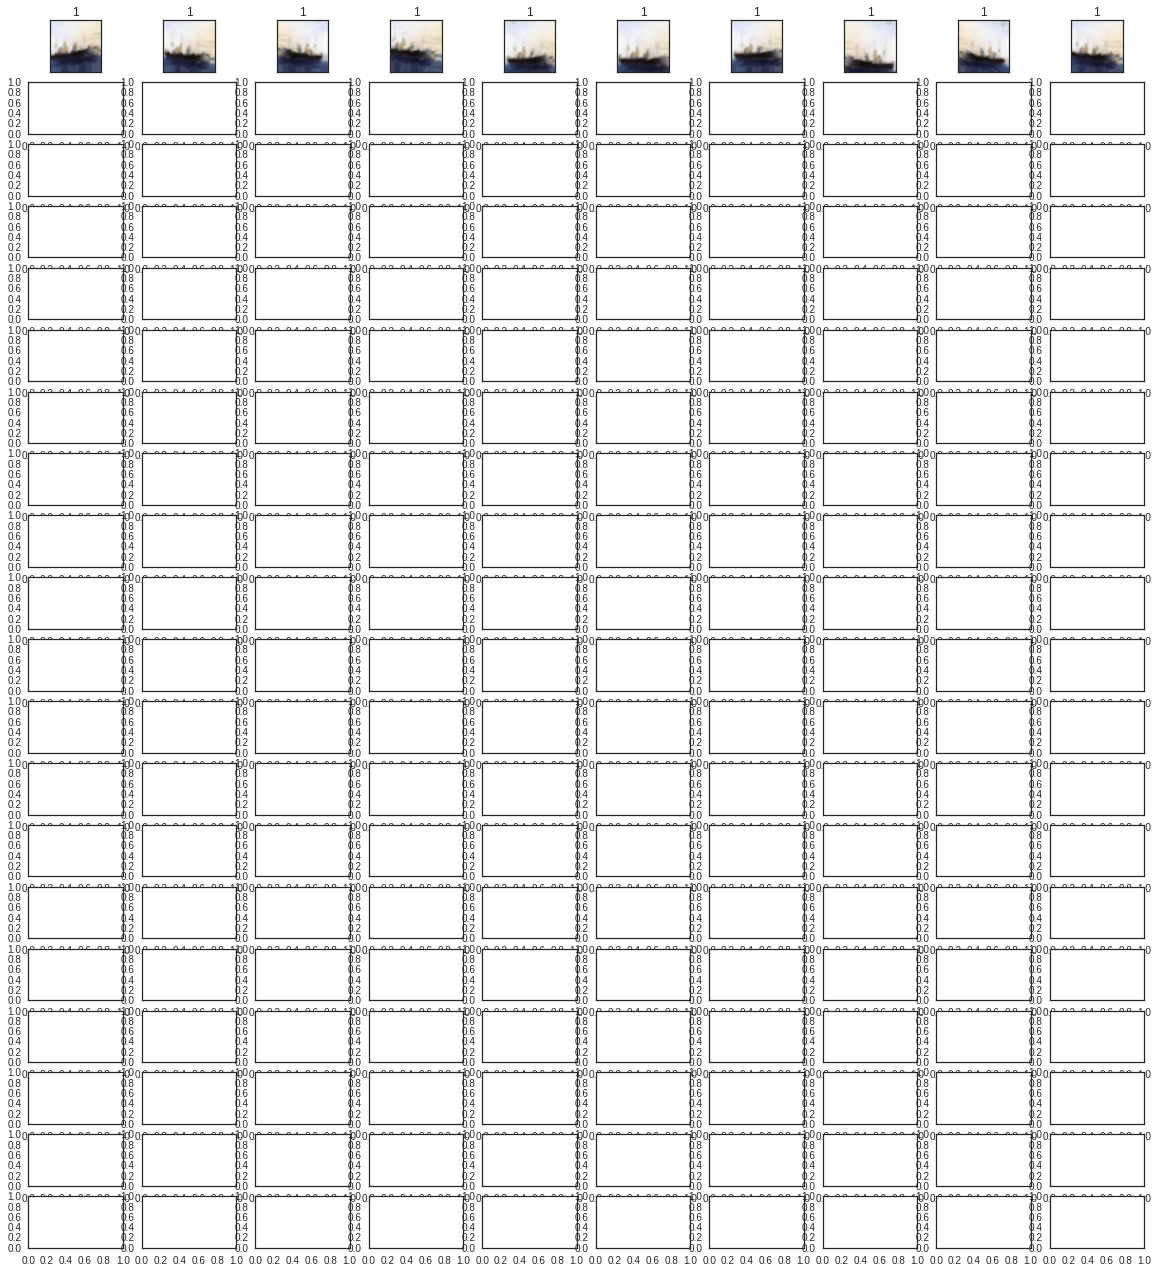

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt

n = 54000  # how many digits we will display
rows=20
columns=10
fig, axs = plt.subplots(rows,columns,figsize=(20, 22))

#plt.gray()
#fig.subplots_adjust(hspace = .5, wspace=.001)

#for r in range(rows):
r=0
c=0

image = generated_images_train.reshape(generated_images_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
#image = image*127.5+127.5
image = image*255


for i in range(n):
    if np.argmax(generated_labels_train[i]) == 1:
        axs[r, c].imshow(Image.fromarray(image[i].astype(np.uint8)))
        axs[r, c].set_title(np.argmax(generated_labels_train[i]))
        axs[r, c].get_xaxis().set_visible(False)
        axs[r, c].get_yaxis().set_visible(False)
        #print (r,c)
        c=c+1
        if c==10:
            #print ('breaking to next row')
            r=r+1
            c=0

plt.show()


In [25]:
unsup_feature_layers = [
    Convolution2D(32,3, 3, border_mode='same',input_shape=(3, 32, 32), activation='relu'),
    Convolution2D(32,3, 3, border_mode='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),
    Convolution2D(64,3, 3, border_mode='same',activation='relu'),
    Convolution2D(64,3, 3, border_mode='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),
    Convolution2D(86,3, 3, border_mode='same',activation='relu'),
    Convolution2D(86,3, 3, border_mode='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout (0.25),
    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu")
    #Dense(512, activation = "relu"),   
    #Dense(256, W_regularizer=keras.regularizers.l2(0.01)),
    #Activation('sigmoid')  
]
# try spliting to feature layers, a encoder layer and a classification layer
# havings sigmoid in between is killing the calssification accuracy
# in version 2 - a relu layer before softmax is performing beutifully well
unsup_classification_layers = [
    Dense(no_of_surrogate_classes, activation='softmax', W_regularizer=keras.regularizers.l2(0.01), name='fc_layer2')
]

In [26]:
#print model.summary()

unsupmodel = Sequential(unsup_feature_layers + unsup_classification_layers)


#Set the CNN model for Unsupervised training
unsupmodel = Sequential()
#model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 # activation ='relu', input_shape = (32,32,3)))
unsupmodel.add(Convolution2D(32,3, 3, border_mode='same',input_shape=(3, 32, 32), activation='relu'))

#model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
unsupmodel.add(Convolution2D(32,3, 3, border_mode='same',activation='relu'))
unsupmodel.add(MaxPooling2D(pool_size=(2,2)))
unsupmodel.add(BatchNormalization())
unsupmodel.add(Dropout(0.25))


#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
unsupmodel.add(Convolution2D(64,3, 3, border_mode='same',activation='relu'))

#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))

unsupmodel.add(Convolution2D(64,3, 3, border_mode='same',activation='relu'))

unsupmodel.add(MaxPooling2D(pool_size=(2,2)))
unsupmodel.add(BatchNormalization())
unsupmodel.add(Dropout(0.25))

#model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
unsupmodel.add(Convolution2D(86,3, 3, border_mode='same',activation='relu'))


#model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
unsupmodel.add(Convolution2D(86,3, 3, border_mode='same',activation='relu'))

unsupmodel.add(MaxPooling2D(pool_size=(2,2)))
unsupmodel.add(BatchNormalization())
unsupmodel.add(Dropout(0.25))


unsupmodel.add(Flatten())
unsupmodel.add(Dense(1024, activation = "relu"))
unsupmodel.add(Dropout(0.5))
unsupmodel.add(Dense(512, activation = "relu"))
unsupmodel.add(Dense(no_of_surrogate_classes, activation = "softmax"))

In [27]:
from keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(lr=0.001, decay=1e-6)

In [28]:
# Compile the model
unsupmodel.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [29]:
unsupmodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 16, 16)    64          maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [30]:
# Set a learning_rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
nb_epochs=20
batch_size = 128
kfold_weights_path = os.path.join('weights_' +  'CIFAR10-ExemplarMethod-Semi_Supervised_Ver3.2' +
                                  '_epoch_'+str(nb_epochs)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_CIFAR10-ExemplarMethod-Semi_Supervised_Ver3.2_epoch_20_batch_128.h5


In [32]:
os.path.isfile(kfold_weights_path)

True

In [33]:
# Some transfer learning
if os.path.isfile(kfold_weights_path):
    print ('Loading already stored weights...')
    unsupmodel.load_weights(kfold_weights_path)
else:
    print ('Training for the first time...')
    

Loading already stored weights...


In [34]:
nb_epochs=2

In [34]:
callbacks = [
                EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', 
                                save_best_only=True, 
                                verbose=1),
                ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
            ]
unsupmodel.fit(generated_images_train, generated_labels_train,
            nb_epoch=nb_epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(generated_images_val, generated_labels_val),
            callbacks=callbacks
            )

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 346s - loss: 0.7882 - acc: 0.8787 - val_loss: 0.3825 - val_acc: 0.9570
Epoch 2/20
45000/45000 [==============================] - 354s - loss: 0.5307 - acc: 0.9117 - val_loss: 0.3199 - val_acc: 0.9550
Epoch 3/20
45000/45000 [==============================] - 358s - loss: 0.4371 - acc: 0.9189 - val_loss: 0.3288 - val_acc: 0.9396
Epoch 4/20
45000/45000 [==============================] - 359s - loss: 0.3818 - acc: 0.9250 - val_loss: 0.1904 - val_acc: 0.9714
Epoch 5/20
45000/45000 [==============================] - 354s - loss: 0.3408 - acc: 0.9300 - val_loss: 0.3714 - val_acc: 0.9228
Epoch 6/20
45000/45000 [==============================] - 358s - loss: 0.3180 - acc: 0.9339 - val_loss: 0.2265 - val_acc: 0.9536
Epoch 7/20
45000/45000 [==============================] - 360s - loss: 0.3041 - acc: 0.9361 - val_loss: 0.2767 - val_acc: 0.9438
Epoch 8/20
44928/45000 [========================

In [35]:
print (generated_images_train.shape)
print (generated_labels_train.shape)
print (generated_images_val.shape)
print (generated_labels_val.shape)

(45000, 3, 32, 32)
(45000, 1000)
(5000, 3, 32, 32)
(5000, 1000)


## Start Semi-Supervised by Combining both Supervised and Unsupervised 

In [38]:
# Now that we have generated a weights file
# we need a method to do some transfer learning
# train the last few layers to predict the original 10 classes


In [39]:
# use the seed samples selected to do supervised training and check how well the 
# unsupervised model has learned

In [74]:
ss_feature_layers = [
    Convolution2D(32,3, 3, border_mode='same',input_shape=(3, 32, 32), activation='relu'),
    Convolution2D(32,3, 3, border_mode='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),
    Convolution2D(64,3, 3, border_mode='same',activation='relu'),
    Convolution2D(64,3, 3, border_mode='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),
    Convolution2D(86,3, 3, border_mode='same',activation='relu'),
    Convolution2D(86,3, 3, border_mode='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout (0.25),
    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu")
    #Dense(512, activation = "relu"),   
    #Dense(256, W_regularizer=keras.regularizers.l2(0.01)),
    #Activation('sigmoid')  
]
# try spliting to feature layers, a encoder layer and a classification layer
# having sigmoid in between is killing the calssification accuracy
# in version 2 - a relu layer before softmax is performing beutifully well
# after transfer learning i think we need a dense layer before the softmax activation
# it is causing the below valueerror hence introducing a dense 256 layer as in the original
#ValueError: GpuElemwise. Input dimension mis-match.
##Input 1 (indices start at 0) has shape[1] == 1000, but the output's size on that axis is 11.
#classification_layers = [
#    Dense(11, activation='softmax', W_regularizer=keras.regularizers.l2(0.01), name='fc_layer2')
#]

ss_classification_layers = [
    Dense(256, activation = "relu", W_regularizer=keras.regularizers.l2(0.01), name='ss_fc_layer1'),
    ## Can Relu improve? instead of Sigmoid
    Dense(11, activation='softmax', W_regularizer=keras.regularizers.l2(0.01), name='ss_fc_layer2')
]


In [75]:
#print model.summary()

semisupmodel = Sequential(ss_feature_layers + ss_classification_layers)


In [76]:
from keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(lr=0.001, decay=1e-6)

In [77]:
# Compile the model
semisupmodel.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [78]:
semisupmodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 32, 32, 32)    9248        convolution2d_13[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_14[0][0]           
____________________________________________________________________________________________________
batchnormalization_7 (BatchNorma (None, 32, 16, 16)    64          maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [79]:
os.path.isfile(kfold_weights_path)

True

In [80]:
print (kfold_weights_path)

weights_CIFAR10-ExemplarMethod-Semi_Supervised_Ver3.2_epoch_20_batch_128.h5


In [81]:
semisupmodel.load_weights(kfold_weights_path, by_name=True)

for l in ss_feature_layers:
    print (l)
    l.trainable = False
    #l.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print('Model Compilation successful')

lr = 0.1

sgd = SGD(lr=lr, decay=1e-5, momentum=0.8, nesterov=True)

model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [82]:
semisupmodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 32, 32, 32)    9248        convolution2d_13[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_14[0][0]           
____________________________________________________________________________________________________
batchnormalization_7 (BatchNorma (None, 32, 16, 16)    64          maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [45]:
print(l_images_train.shape)


(2000, 3, 32, 32)


In [46]:
print (l_images_train[0])

[[[ 0.30196078  0.29803922  0.31372549 ...,  0.29803922  0.2745098
    0.23529412]
  [ 0.31764706  0.30980392  0.3254902  ...,  0.3254902   0.30196078
    0.23529412]
  [ 0.28235294  0.29803922  0.30980392 ...,  0.34117647  0.30980392
    0.25098039]
  ..., 
  [ 0.6745098   0.64313725  0.63921569 ...,  0.69803922  0.63529412
    0.60392157]
  [ 0.64705882  0.68627451  0.65490196 ...,  0.69411765  0.62352941
    0.56470588]
  [ 0.64705882  0.69019608  0.6745098  ...,  0.71764706  0.64705882
    0.57647059]]

 [[ 0.31764706  0.30980392  0.32941176 ...,  0.30196078  0.28235294
    0.24705882]
  [ 0.32941176  0.32156863  0.34117647 ...,  0.32941176  0.30588235
    0.24313725]
  [ 0.29411765  0.30980392  0.32156863 ...,  0.34117647  0.30980392
    0.25490196]
  ..., 
  [ 0.6745098   0.64705882  0.63921569 ...,  0.67843137  0.62352941
    0.60784314]
  [ 0.64313725  0.68235294  0.64705882 ...,  0.67843137  0.61960784
    0.57254902]
  [ 0.64313725  0.68627451  0.67058824 ...,  0.70196078  0.

In [47]:
# concatenate unsup and sup images
X_Train_Comb = np.concatenate((generated_images_train, l_images_train))

In [48]:
print (X_Train_Comb.shape)


(47000, 3, 32, 32)


In [49]:
generated_images_pseudo_label = np.zeros([len(generated_images_train),1])
print (generated_images_pseudo_label.shape)
# the pseudo-label can be other than -1, try 10 as the 11th label
generated_images_pseudo_label.fill(10)


(45000, 1)


In [50]:
print (generated_images_pseudo_label.shape)
print (generated_images_pseudo_label)

(45000, 1)
[[ 10.]
 [ 10.]
 [ 10.]
 ..., 
 [ 10.]
 [ 10.]
 [ 10.]]


In [51]:
print (l_labels_train.shape)


(2000, 10)


In [52]:
l_labels_train = np.argmax(l_labels_train,axis=1)

In [53]:
print (l_labels_train.shape)


(2000,)


In [54]:
l_labels_train = l_labels_train.reshape(len(l_labels_train),1)


In [55]:
print (l_labels_train.shape)


(2000, 1)


In [56]:
l_labels_train


array([[4],
       [4],
       [5],
       ..., 
       [8],
       [8],
       [8]])

In [57]:
# concatenate unsup and sup images
Y_Train_Comb = np.concatenate((generated_images_pseudo_label, l_labels_train))

In [58]:
print (Y_Train_Comb.shape)


(47000, 1)


In [59]:
print (Y_Train_Comb)


[[ 10.]
 [ 10.]
 [ 10.]
 ..., 
 [  8.]
 [  8.]
 [  8.]]


In [60]:
Y_Train_Comb = np_utils.to_categorical(Y_Train_Comb, 11)

In [61]:
print (Y_Train_Comb.shape)


(47000, 11)


In [63]:
Y_Train_Comb

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [64]:
# Set a learning_rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [83]:
nb_epochs=20
batch_size = 128
ss_kfold_weights_path = os.path.join('weights_' +  'CIFAR10-ExemplarMethod-Semi_Supervised_Ver3.21ss' +
                                  '_epoch_'+str(nb_epochs)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(ss_kfold_weights_path)

weights_CIFAR10-ExemplarMethod-Semi_Supervised_Ver3.21ss_epoch_20_batch_128.h5


In [85]:
os.path.isfile(ss_kfold_weights_path)

False

In [68]:
from sklearn.model_selection import train_test_split
ss_images_train, ss_images_val, ss_labels_train, ss_labels_val = \
train_test_split(X_Train_Comb, Y_Train_Comb,test_size=0.1, random_state=42)

In [86]:
print (ss_images_train.shape)
print (ss_labels_train.shape)
print (ss_images_val.shape)
print (ss_labels_val.shape)

(42300, 3, 32, 32)
(42300, 11)
(4700, 3, 32, 32)
(4700, 11)


In [87]:
callbacks = [
                EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                ModelCheckpoint(ss_kfold_weights_path, monitor='val_loss', 
                                save_best_only=True, 
                                verbose=1),
                ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
            ]
semisupmodel.fit(ss_images_train, ss_labels_train,
            nb_epoch=nb_epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(ss_images_val, ss_labels_val),
            callbacks=callbacks
            )

Train on 42300 samples, validate on 4700 samples
Epoch 1/20
42300/42300 [==============================] - 318s - loss: 0.9297 - acc: 0.9547 - val_loss: 0.1746 - val_acc: 0.9594
Epoch 2/20
42300/42300 [==============================] - 317s - loss: 0.1711 - acc: 0.9572 - val_loss: 0.1463 - val_acc: 0.9594
Epoch 3/20
42300/42300 [==============================] - 318s - loss: 0.1518 - acc: 0.9572 - val_loss: 0.2016 - val_acc: 0.9594
Epoch 4/20
42300/42300 [==============================] - 318s - loss: 0.1428 - acc: 0.9577 - val_loss: 0.2260 - val_acc: 0.9474
Epoch 5/20
42300/42300 [==============================] - 318s - loss: 0.1347 - acc: 0.9588 - val_loss: 0.1363 - val_acc: 0.9596
Epoch 6/20
42300/42300 [==============================] - 318s - loss: 0.1324 - acc: 0.9593 - val_loss: 0.1301 - val_acc: 0.9596
Epoch 7/20
42300/42300 [==============================] - 318s - loss: 0.1284 - acc: 0.9593 - val_loss: 0.1502 - val_acc: 0.9602
Epoch 8/20
42300/42300 [========================

In [88]:
x_test

array([[[[ 0.61960784,  0.62352941,  0.64705882, ...,  0.5372549 ,
           0.49411765,  0.45490196],
         [ 0.59607843,  0.59215686,  0.62352941, ...,  0.53333333,
           0.49019608,  0.46666667],
         [ 0.59215686,  0.59215686,  0.61960784, ...,  0.54509804,
           0.50980392,  0.47058824],
         ..., 
         [ 0.26666667,  0.16470588,  0.12156863, ...,  0.14901961,
           0.05098039,  0.15686275],
         [ 0.23921569,  0.19215686,  0.1372549 , ...,  0.10196078,
           0.11372549,  0.07843137],
         [ 0.21176471,  0.21960784,  0.17647059, ...,  0.09411765,
           0.13333333,  0.08235294]],

        [[ 0.43921569,  0.43529412,  0.45490196, ...,  0.37254902,
           0.35686275,  0.33333333],
         [ 0.43921569,  0.43137255,  0.44705882, ...,  0.37254902,
           0.35686275,  0.34509804],
         [ 0.43137255,  0.42745098,  0.43529412, ...,  0.38431373,
           0.37254902,  0.34901961],
         ..., 
         [ 0.48627451,  0.392156

In [89]:
y_test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [90]:
y_test.shape

(10000, 10)

In [91]:
y_test = np.ndarray.argmax(y_test,axis=1)

In [92]:
y_test.shape

(10000,)

In [93]:
y_test = np_utils.to_categorical(y_test, 11)

In [94]:
y_test.shape

(10000, 11)

In [95]:
y_test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [72]:
score = semisupmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.57058504868
Test accuracy: 0.0


In [73]:
x_test[1]

array([[[ 0.92156863,  0.90588235,  0.90980392, ...,  0.91372549,
          0.91372549,  0.90980392],
        [ 0.93333333,  0.92156863,  0.92156863, ...,  0.9254902 ,
          0.9254902 ,  0.92156863],
        [ 0.92941176,  0.91764706,  0.91764706, ...,  0.92156863,
          0.92156863,  0.91764706],
        ..., 
        [ 0.34117647,  0.16862745,  0.0745098 , ...,  0.6627451 ,
          0.71372549,  0.7372549 ],
        [ 0.32156863,  0.18039216,  0.14117647, ...,  0.68235294,
          0.7254902 ,  0.73333333],
        [ 0.33333333,  0.24313725,  0.22745098, ...,  0.65882353,
          0.70588235,  0.72941176]],

       [[ 0.92156863,  0.90588235,  0.90980392, ...,  0.91372549,
          0.91372549,  0.90980392],
        [ 0.93333333,  0.92156863,  0.92156863, ...,  0.9254902 ,
          0.9254902 ,  0.92156863],
        [ 0.92941176,  0.91764706,  0.91764706, ...,  0.92156863,
          0.92156863,  0.91764706],
        ..., 
        [ 0.38823529,  0.2       ,  0.09019608, ...,

In [96]:
y_pred = semisupmodel.predict(x_test)

In [97]:
y_pred[0]

array([  3.01892292e-02,   1.16203120e-03,   3.85981612e-02,
         2.05297209e-02,   2.54299901e-02,   1.20777292e-02,
         1.46516217e-02,   6.57828478e-03,   1.08419880e-02,
         4.06319101e-04,   8.39534760e-01], dtype=float32)

In [98]:
y_test[0]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [99]:
y_pred_new = y_pred[:, :10]  # First 10 columns of full_array


In [100]:
y_pred_new[0]

array([ 0.03018923,  0.00116203,  0.03859816,  0.02052972,  0.02542999,
        0.01207773,  0.01465162,  0.00657828,  0.01084199,  0.00040632], dtype=float32)

In [101]:
y_pred_new = np.ndarray.argmax(y_pred_new,axis=1)

In [102]:
y_pred_new[0]

2

In [103]:
y_pred_new.shape

(10000,)

In [104]:
y_pred_new

array([2, 8, 1, ..., 5, 6, 6])

In [105]:
y_test_new = np.ndarray.argmax(y_test,axis=1)

In [106]:
y_test_new

array([3, 8, 8, ..., 5, 1, 7])

In [107]:
num=10000
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred_new[i].all() == y_test_new[i].all():
        if np.array_equal(y_pred_new[i],y_test_new[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")

tested  10000 digits
correct:  2537 wrong:  7463 error rate:  74.63 %
got correctly  25.37 %


In [108]:
unique, counts = numpy.unique(y_test_new, return_counts=True)
print (dict(zip(unique, counts)))

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [109]:
unique, counts = numpy.unique(y_pred_new, return_counts=True)
print (dict(zip(unique, counts)))

{0: 776, 1: 2309, 2: 213, 4: 770, 5: 817, 6: 3930, 7: 82, 8: 1103}
